# Detecting Faces: Using a CNN model to Classify Unseen Faces in the 'Labelled Faces in the Wild' Dataset

The 'Labelled Faces in the Wild' (LFW) data set is a collection of 13,233 images of celebrity faces collected from the web, with the individual in each image manually labelled. The dataset is designed for exploring, creating and testing image recognition algorithms.<br/>



The notebook is structured as follows:

**1. Library Installation and Data Read-in** <br/>
Rudimentary data cleaning to ensure data is structured in intuitive data frames <br/>
**2. Exploratory Data Analysis (EDA)** <br/>
Data exploration, visualisations, and splitting the data into training/test/validation sets <br/>
**3. Evaluation Metric Decisions** <br/>
What is the most meaningful evaluation metric to use in this situation? <br/>
**4. Model Construction** <br/>
We discuss a number of candidate computer vision (CV) algorithms and assess the accuracy of CNN techniques on test data <br/>
**5. Results Analysis** <br/>
Discussion of results and their interpretations <br/>
**6. Conclusion and Next Steps** <br/>
A discussion of this approach, real-world applications, limitations, and possible future extensions

# 1. Library installation and data read-in

In [ ]:
# general functions
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# identifying faces
%pip install mtcnn
from mtcnn.mtcnn import MTCNN
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output

dataset_path = "../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"

     |████████████████████████████████| 2.3MB 2.8MB/s 
  Created wheel for mtcnn: filename=mtcnn-0.0.9-cp36-none-any.whl size=2257690 sha256=69471f6d88e29d6b510504fe0600c16d28c2141eac10191cee9c984fa1abf7d3
  Stored in directory: /tmp/.cache/pip/wheels/85/81/65/6363fa5aafd7a155c896591e0c7c6e27b69642aa82b9cbf076
Successfully built mtcnn
Note: you may need to restart the kernel to use updated packages.


Using TensorFlow backend.


In [ ]:
# Data read-in and cleaning

lfw_allnames = pd.read_csv("../input/lfw-dataset/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("../input/lfw-dataset/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("../input/lfw-dataset/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("../input/lfw-dataset/pairs.csv")
# tidy pairs data: 
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("../input/lfw-dataset/people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("../input/lfw-dataset/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("../input/lfw-dataset/peopleDevTrain.csv")

# 2. Exploratory Data Analysis (EDA)

In [ ]:
print("Summary:")
print("There are " + 
      str(lfw_allnames.shape[0]) + 
      " unique celebrities in the entire dataset, of whom " + 
      str(sum(lfw_allnames.images > 1)) + 
      " are represented by multiple images. The entire number of images available is " + 
      str(sum(lfw_allnames.images)) + 
      ". The most represented celebrity is " + 
      str(lfw_allnames.iloc[lfw_allnames['images'].idxmax()][0]) + 
      ", with " + 
      str(max(lfw_allnames.images)) + 
      " unique images in the dataset.")

Summary:
There are 5749 unique celebrities in the entire dataset, of whom 1680 are represented by multiple images. The entire number of images available is 13233. The most represented celebrity is George_W_Bush, with 530 unique images in the dataset.


It is useful to gain an understanding of how the data is structured before we begin building the model. Using (omitted) exploratory code and information provided in the LDW dataset, a summary of the available files follows below:

**lfw_allnames.csv**: a CSV containing two columns; name (a list of all names in the entire dataset) and images (the number of images available for the each name) <br/>
**matchpairsDevTest**: a random sample of 500 image pairs featuring the same individual, with columns for the name and the two image labels <br/>
**matchpairsDevTrain**: a random sample of 1100 image pairs featuring the same individual, with columns for the name and the image labels <br/>
**mismatchpairsDevTest**: a random sample of 500 image pairs featuring different individuals, with columns for both names and the two image labels <br/>
**mismatchpairsDevTrain**: a random sample of 1100 image pairs featuring different individuals, with columns for both names and the two image labels <br/>
**pairs.csv**: 6000 pairs of images, both matched and mismatched. Matched pair rows contain a name and two image files, while unmatched pair rows contain a name for each of the images. For further formating, these two sets of rows will be split into matched_pairs and unmatched_pairs data frames <br/>
**people.csv**: list of names and image counts, identical to lfw_allnames.csv once null values have been removed. Omit from further analysis <br/>
**peopleDevTest.csv**: 1711 individuals in the dataset designed for testing: columns for celebrity name and image count (zero overlap with peopleDevTrain.csv) <br/>
**peopleDevTrain.csv**: 4038 individuals in the dataset designed for training: columns for celebrity name and image count (zero overlap with peopleDevTest.csv) <br/>

 

### Data reshaping and train/test split

We need to define the objective more clearly before we create the train/test split. What are we trying to achieve with this project?<br/>

The flow of the project should be as follows: <br/>
1. Build a model on the training data that can predict the names associated with images <br/>
The training set should incorporate multiple images of some individuals, to equip the model with knowledge of how to deal with the same face in different situations
2. Test the model on new images and predict the identity <br/>
The test set needs to incorporate some individuals that we have seen in the training set (although not the same images) and some individuals that we haven't, to test the algorithm's accuracy

Therefore, we need to split the data into training and test data.

In [ ]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index",1)
lfw_test = lfw_test.reset_index().drop("index",1)

# verify that there is a mix of seen and unseen individuals in the test set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

# both comprehensively non-empty - we are ok to procede.
# N.B. although we don't use this training/test split in the following model, this is the format of the data we
# would use in applying models to the full dataset

862
846


### Image format exploration

In [ ]:
# verify resolution of all images is consistent
widths = []
heights = []
files = image_paths.image_path
for file in files:
    path = "../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(file)
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)

pd.DataFrame({'height':heights,'width':widths}).describe()

# all 250 x 250 resolution

,height,width
count,13233.0,13233.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


### Further data exploration

In [ ]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1])) + " individuals, which is " + str(round(100*(sum(ind_counts[ind_counts==1])/sum(ind_counts)))) + "% of the total individuals considered, are only represented by a single image in this dataset.")

4069 individuals, which is 31% of the total individuals considered, are only represented by a single image in this dataset.


As a sanity check, and to check the directories are all correctly connected, we visualize a sample image:

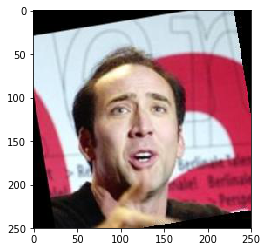

In [ ]:
im = Image.open("../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
plt.imshow(im)

# 3. Evaluation Metric Decisions
There is one final question to consider before building a model: what do we mean by accuracy? What constitutes a successful model? 

**Accuracy** is defined as

$$ acc = {\frac{tp+tn}{n}} $$

Where *tp* is the number of true positive predictions, *tn* is the number of true negative predictions, and *n* is the total number of predictions. In other words, it is the proportion of all predictions that are correct. Accuracy is a useful indicator that our model performs well, but ignores the nuance that false positives and false negatives may have different costs associated with them. It also performs badly when there is a large class imbalance, which is a key consideration in the LFW dataset. 

In the following models, we consider two key metrics: precision and recall. The **precision** of a model for predicted class x is defined as

$$ prec_{x} = {\frac{tp_{x}}{tp_{x}+fp_{x}}} $$

Where *fp*<sub>x</sub> is the number of false positive predictions for class x. In other words, precision represents the proportion of all images that are *predicted* to be in class x that *actually* belong to class x. The **recall** of a model for predicted class x is defined as

$$ rec_{x} = {\frac{tp_{x}}{tp_{x}+fn_{x}}} $$

Where *fn*<sub>x</sub> is the number of false negative predictions for class x. Recall indicates the proportion of all images that are *actually* in class x that are *predicted* to be in class x. It is also possible to combine precision and recall into an F1 score, but for the purposes of this notebook it is interesting to consider the real-world implications of the separate metrics.



# 4. Model Construction
## 4. a. Preliminary Model: Detecting Faces


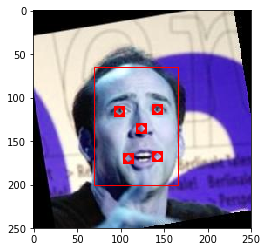

In [ ]:
# Use out-of-the-box MTCNN algorithm to identify facial boundaries on a sample image
detector = MTCNN()
image = cv2.imread("../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
result = detector.detect_faces(image)
# That's it - the results have already been generated! Now we extract the boundaries that have been identified 
bounding_box = result[0]['box']
keypoints = result[0]['keypoints']

# Finally, we plot the image along with the face's bounding box and internal features (eyes, nose, and mouth corners)
fig,ax = plt.subplots(1)
ax.imshow(image)
# Create a Rectangle patch
rect = patches.Rectangle(bounding_box[0:2],bounding_box[2],bounding_box[3],linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
# Visualize all the internal features
for key in keypoints:
    rect_key = patches.Rectangle(keypoints[key],1,1,linewidth=10,edgecolor='r',facecolor='none')
    ax.add_patch(rect_key)
# Show the plots
plt.show()

We don't use these features in the main CNN models below, but they would be useful feature inputs for future models.

## 4. b. Classifying Faces: CNN Approach on a Simplified Dataset
In this Section we will implement a classic CNN algorithm on the LFW dataset. Before we build any models, it is important to understand the structure and purpose of a CNN. There is a wealth of literature available, but the main themes are briefly synthesised below.

A Convolutional Neural Network (CNN) is a neural network used primarily for image analysis. Its primary insight is that image regions can be scanned to obtain lower-dimensional "convolved" representations that preserve the relationships between pixel areas. There are 4 key steps in a CNN:

1. **Convolution**: convolve the images using a feature detector to obtain a feature map (e.g. edge detection)
2. **Non-Linearity**: create non-linearities in the data using a non-linear activation function
3. **Pooling**: reduce dimension of the feature maps further by considering average convolved values in a region
4. **Connect the layers**: organise all previous aspects of the model into a fully connected network that can be used to generate model predictions

The network is then trained using back-propagation.

In [ ]:
not_george = image_paths[image_paths.name!="George_W_Bush"].sample(530)
not_george.name = "not_George"
GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
                     not_george])

In [ ]:
# withhold final test data
bush_train, bush_test = train_test_split(GWB_data, test_size=0.2)
#  It is also useful to reserve a validation set in the training data, for use in the model construction
bush_train, bush_val = train_test_split(bush_train,test_size=0.2)

In [ ]:
# initialize sequential network
from keras.models import Sequential
# include convolutional layers
from keras.layers import Conv2D
# Pooling layers
from keras.layers import MaxPooling2D
# flatten layers into single vector
from keras.layers import Flatten
from keras.layers import Dense

In [ ]:
# use sequential classifier - standard CNN implementation with straightforward single input
Bush_classifier = Sequential()
# We then add layers of complexity to this classifier. The first layer we add is a 2D convolutional layer (as 
# explained above); we pass over the image with a 3x3 window and expect 250*250 pixel input.
# The activation function to introduce non-linearity  is 'relu': Rectified Linear Units, a simple activation function 
# with low computational speeds. One potential downside is that ReLU can lead to "dying neurons", where a neuron is 
# attributed zero influence on classification and gets stuck in this state; we can see output where many neurons have 
# zero influence on the model. If this behaviour manifested in further analysis, an alternate activation function e.g. 
# 'leaky ReLU' would be worth exploring as an alternative
Bush_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))

# We now add the pooling layer to reduce the dimension
Bush_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# The next step is to flatten the data, reducing the feature maps to a 1D array
Bush_classifier.add(Flatten())

# We then add a fully connected layer - traditional Multi Layer Perceptron
Bush_classifier.add(Dense(units = 128, activation = 'relu'))

# as we are just training on 'Bush' vs 'non-Bush', we only need to add one classification unit
Bush_classifier.add(Dense(units = 1, activation = 'sigmoid'))

# We are now ready to compile the model. It is possible, and advisable, to introduce more layers to the network, but
# as this model is exploratory we are keeping things straightforward for now (this would change in future iterations)
Bush_classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

The model is now ready to run, but there is a final step required: the model will read training files from a dedicated training folder, so we need to make sure all the images are in folders with the correct labels. 

In [ ]:
# define a custom function to move images to a new train/test/val directory

def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('/kaggle/working/',dir_name)):
            shutil.os.mkdir(os.path.join('/kaggle/working/',dir_name))
        
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('/kaggle/working/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('/kaggle/working/',dir_name,data_type))
        path_from = os.path.join('../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/',image)
        path_to = os.path.join('/kaggle/working/',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1
        
    print('Moved {} images to {} folder.'.format(co,dir_name))

In [ ]:
# move images:
directory_mover(bush_train,"Bush_train/")
directory_mover(bush_val,"Bush_val/")
directory_mover(bush_test,"Bush_test/")


Moved 678 images to Bush_train/ folder.
Moved 170 images to Bush_val/ folder.
Moved 212 images to Bush_test/ folder.


Now all the images are in the relevant training/test folders, we can run our CNN algorithm.

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
Bush_training_set = train_datagen.flow_from_directory('/kaggle/working/Bush_train/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
Bush_val_set = test_datagen.flow_from_directory('/kaggle/working/Bush_val/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')
Bush_test_set = test_datagen.flow_from_directory('/kaggle/working/Bush_test/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


In [ ]:
Bush_history = Bush_classifier.fit_generator(Bush_training_set,
                                             # set steps per epoch equal to the number of training images
                                             steps_per_epoch = 678,
                                             # there is a six hour runtime limit on Kaggle Kernels, restricting the maximum epoch number
                                             epochs = 8,
                                             validation_data = Bush_val_set,
                                             validation_steps = 100)

Epoch 1/8
678/678 [==============================] - 1072s 2s/step - loss: 0.4246 - accuracy: 0.8682 - val_loss: 0.2098 - val_accuracy: 0.9238
Epoch 2/8
678/678 [==============================] - 1066s 2s/step - loss: 0.0723 - accuracy: 0.9743 - val_loss: 0.6040 - val_accuracy: 0.9176
Epoch 3/8
678/678 [==============================] - 1069s 2s/step - loss: 0.0626 - accuracy: 0.9772 - val_loss: 0.0028 - val_accuracy: 0.9406
Epoch 4/8
678/678 [==============================] - 1068s 2s/step - loss: 0.0301 - accuracy: 0.9892 - val_loss: 0.0705 - val_accuracy: 0.9350
Epoch 5/8
678/678 [==============================] - 1070s 2s/step - loss: 0.0398 - accuracy: 0.9870 - val_loss: 0.1409 - val_accuracy: 0.9533
Epoch 6/8
678/678 [==============================] - 1066s 2s/step - loss: 0.0340 - accuracy: 0.9880 - val_loss: 1.4144 - val_accuracy: 0.9590
Epoch 7/8
678/678 [==============================] - 1073s 2s/step - loss: 0.0117 - accuracy: 0.9962 - val_loss: 0.2518 - val_accuracy: 0.9765

Now that the model is operational, we can look at the relationship between the training and validation loss to see if overfitting is likely to have taken place:

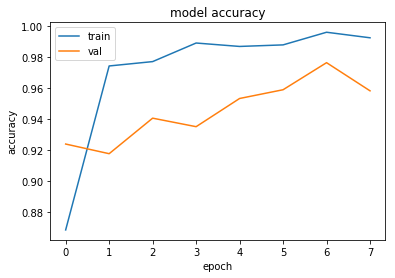

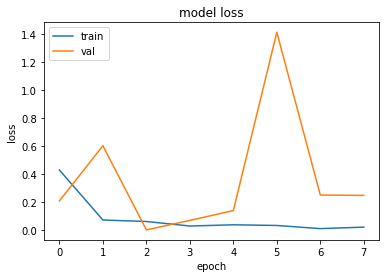

In [ ]:
plt.plot(Bush_history.history['accuracy'])
plt.plot(Bush_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(Bush_history.history['loss'])
plt.plot(Bush_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Given the relatively low number of epochs, the model still appears to be converging - the validation loss/accuracy is instable, which is also a function of the validation method (in future iterations, cross validation would be a preferable method). However, accuracy is generally high on both sets, indicating that the model is performing well. To confirm the model's performance, we look at the precision and recall on the (unseen) test set, comparing accuracy with the true labels:

In [ ]:
from keras.preprocessing import image

# create a function to predict class of images in a directory, given a trained classifier
def predictions(dir_name,classifier,binary):
    # dir_name should include name of predicted invididual - could edit this to iterate through folders in future
    predictions = []
    for im in os.listdir(dir_name):
        test_image = image.load_img(dir_name + str(im), target_size = (250,250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        if(binary is True):
            result = float(str(classifier.predict(test_image))[2])
        else: 
            result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)


In [ ]:
# classes are passed through the algorithm in a random order - we want to retrieve the order of the classes
Bush_test_names = []
# collect all file names
for i in range(len(Bush_test_set.filenames)):
    Bush_test_names.append(Bush_test_set.filenames[i])
# extract unique names, in order
for i in range(len(Bush_test_names)):
    Bush_test_names[i] = Bush_test_names[i].split("/")[0]
Bush_test_name_order = list(OrderedDict.fromkeys(Bush_test_names))

In [ ]:
# Compute predictions
Bush_predictions_0 = predictions("/kaggle/working/Bush_test/"+ Bush_test_name_order[0] + "/",Bush_classifier,binary = True)
Bush_predictions_1 = predictions("/kaggle/working/Bush_test/"+ Bush_test_name_order[1] + "/",Bush_classifier, binary = True)

# Compare predictions to actual classes
Bush_predictions_frame = pd.DataFrame(list(zip(Bush_predictions_0 + Bush_predictions_1,
                                                [0] * len(Bush_predictions_0) + [1] * len(Bush_predictions_1))),
                                       columns = ['Predictions','Actual'])

In [ ]:
# function for finding the precision and recall of predictions, for any number of predictive classes
def prec_acc(predictions_frame):
    precision = []
    accuracy = []
    recall = []
    for i in range(len(set(predictions_frame.Predictions))):
        tp = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] == i)].shape[0]
        tn = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] != i)].shape[0]
        fp = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] == i)].shape[0]
        fn = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] != i)].shape[0]
        total_preds = predictions_frame.shape[0]
        precision.append(tp/(tp + fp))
        accuracy.append((tp + tn)/total_preds)
        recall.append(tp/(tp + fn))
    return(accuracy,precision,recall)

In [ ]:
Bush_accuracy = prec_acc(Bush_predictions_frame)
print('Precision:' + str(Bush_accuracy[1]))
print('Recall:' + str(Bush_accuracy[2]))
print(Bush_test_name_order)

Precision:[0.8034188034188035, 1.0]
Recall:[1.0, 0.8050847457627118]
['George_W_Bush', 'not_George']


The meaning of these results will be considered further in the conclusion. Before proceding, we clear the workspace to ensure the Kernel can successfully run in the Kaggle infrastructure: